# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [12]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
import sklearn.cluster as clst

import os
import cPickle as pickle
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [3]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [4]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("a.volchanskij") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'DBSCAN. (параметры  - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [92]:
class Clustering:
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.epsilon=float(input('Enter epsilon '))
        self.min_pts=int(input('Enter minimum number of points in cluster '))
        return
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        #Пусть self.range_matrix - матрица расстояний между векторами из self
        self.x_len = len(x)
        self.x_dim = len(x[0,:])
        self.range_matrix = np.ndarray(shape=(self.x_len,self.x_len), dtype=float)
        self.tmp_file = "tmp_%s_%i_%0.2lf"%("range_matrix",len(x),x[0][0])
        #np.zeros(self.range_matrix)
        
        ####################################################
        
        if os.path.exists(self.tmp_file):
            print "Data found"
            with open(self.tmp_file, 'rb') as f:
                data = pickle.load(f)
                self.range_matrix = data
        
        ####################################################
        else:
            print "Start creating matrix"
            sum = 0
            for i in xrange(self.x_len):
                if (i % 100) == 1:
                    print "Current row is ",i," of ",self.x_len
                for j in xrange(self.x_len):
                    if i!=j:
                        self.range_matrix[i,j]=np.sqrt(np.square(x[i]-x[j]).sum())
                    else:
                        if i == j:
                            self.range_matrix[i,j]=0.0
            print "Computing complete, start writing on disk"
            with open(self.tmp_file, "wb") as f: 
                pickle.dump(self.range_matrix,f,2)
                print "The matrix is successfully saved\n\n"
        #print self.range_matrix
                    
                    
                    
                
        #for i in enumerate(self[:,0]):
        #    x=
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        number = 0
        self.non_visited=[]#все векторым пронумеруем, далее работаем только с номерами
        vector_dict = {}
        self.clusters = []
        noise = []
        nbr = []
        nbr1 = []
        C = []
        new_vect = np.ndarray(self.x_dim)
        for i in xrange(self.x_len):
            for j in xrange(self.x_dim):
                new_vect[j]=x[i,j]
            vector_dict[number]=new_vect
            self.non_visited.append(number)
            number+=1
        print self.non_visited
        
        ##########!!!!!!!##########
        
        while len(self.non_visited)!=0:
            vect = self.non_visited[0]
            self.non_visited.remove(vect)
            
            for i in self.non_visited:
                if i<=vect:#учитываем, что матрица верхнедиагональная
                    if self.range_matrix[i,vect]<=self.epsilon:
                        if i not in nbr:
                            nbr.append(i)
                            #self.non_visited.remove(i)
                else:
                    if self.range_matrix[vect,i]<=self.epsilon:
                        if i not in nbr:
                             nbr.append(i)
                            #self.non_visited.remove(i)
                            
                            
                #if (vect == 0):
            if len(nbr) < self.min_pts:
                if vect not in noise:
                    noise.append(vect)
                nbr = []
                        
            else:
                C.append(vect)
                for element in nbr:
                    if element in self.non_visited:
                        self.non_visited.remove(element)
   
                    for i in self.non_visited:
                        if i<=element:#учитываем, что матрица верхнедиагональная
                            if self.range_matrix[i,element]<=self.epsilon:
                                if i not in nbr1:
                                    nbr1.append(i)
                                        #self.non_visited.remove(i)
                            else:
                                if self.range_matrix[element,i]<=self.epsilon:
                                    if (i not in nbr1) and (i not in nbr)  and (i not in C):
                                        nbr1.append(i)
                                            #self.non_visited.remove(i)
                            
                    if len(nbr1)>=self.min_pts:
                        nbr.extend(nbr1)
                    nbr1 = []
                    flag = 0
                    if len(self.clusters)>0:
                        for i in xrange(len(self.clusters)):
                            if element in self.clusters[i]:
                                flag = 1
                                #print"clustered", element,self.clusters[i]
                                break
                    if flag == 0:
                        if element not in C:
                            C.append(element)
                        #print "Y"
                        #print C
                        #print "Y"
                            #print"in_cluster", element
                if len(C)>0:
                    self.clusters.append(C)
                    #print 'Yup'
                    #print self.clusters
                    #print 'Yup'
                C = []
                nbr = []
                nbr1 = []
        if len(noise)>0:
            print "There is some noise"
            self.clusters.append(noise)
        print "List of clusters:"
        print self.clusters
        output = []
        for i in xrange(self.x_len):
            flag = 1
            for j in xrange(len(self.clusters)):
                            ###найти i-ый элемент 
                if i in self.clusters[j]:
                    if flag == 1:
                        if j == (len(self.clusters)-1):
                            output.append(-1)
                        else:
                            output.append(j)
                    flag = 0
        print "Not visited"
        print self.non_visited
        print output
        print "Max dist = ", self.range_matrix.max()
        print "Number of clasters = ", max(output)
        print self.range_matrix[0,:]
                                               
        return output #[random.randint(0,1) for r in xrange(self.x_len)]
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

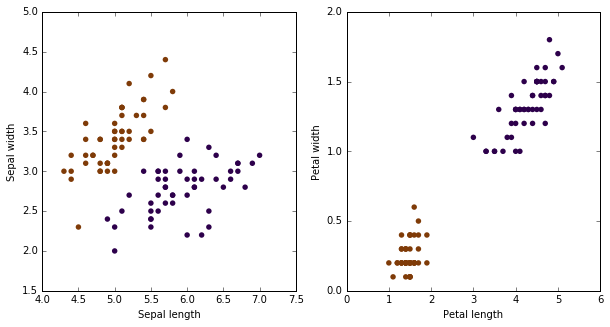

In [6]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
2
pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [8]:
pred_iris = Clustering().fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Enter epsilon 1.7
Enter minimum number of points in cluster 2
Data found
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Yup
Yup
List of clusters:
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 58, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 99, 57, 59, 60, 93, 98]]
Not visited
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

При epsilon = 1.7 и min_pts = 2 Adjusted Rand index for iris is: 1.00

## Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [9]:
def Dist(a,b):
    summ = 0.0
    for i in xrange(len(a)):
        summ += np.power(a[i] - b[i], 2)
    return np.power(summ,1.0/2)

def Silhouette(x, y):
    """
    Implement quality criterion of your choice
    """
    length = len(y)
    clusters = {} # все кластеры
    for elem in y:
        if elem not in clusters: #если такого кластера ещё не было, то добавим в clusters
            clusters[elem] = 1
        else:
            clusters[elem] += 1 
    K = len(clusters)
    a = [0 for p in xrange(length)]
    b = [{} for p in xrange(length)]
    
    for i,elem in enumerate(y):
        print "now computing",i
        if clusters[elem] > 10: #отсекаем выбросы
            for j,clust_elem in enumerate(y):
                if clusters[clust_elem] > 10 and i != j: #отсекаем выбросы
                    if elem == clust_elem:
                        a[i] += Dist(x[i],x[j])/(clusters[clust_elem]-1)
                    else:
                        if clust_elem in b[i]:
                            b[i][clust_elem] += Dist(x[i],x[j]) /(clusters[clust_elem])
                        else:
                            b[i][clust_elem]  = Dist(x[i],x[j])/(clusters[clust_elem])
              
    #a1 --- среднеие растояния до точек соответствующего кластера
    #b1 --- среднее растояние до соседнего(!) кластера, т.е. минимальное из всех растояний
    a1 = [0 for p in xrange(len(y))]
    b1 = [0 for p in xrange(len(y))]
            
    for i,elem in enumerate(y):
        if clusters[elem] > 10:
            a1[i] = a[i]
            min_c = inf
            for c in b[i]:
                if min_c > b[i][c]: min_c = b[i][c]
            if min_c != inf:
                b1[i] = min_c
                
      
    S = 0.0
    lenn = 0
    for elem in xrange(length):
        if b1[elem] != 0 or a1[elem] != 0:
            if b1[elem] > a1[elem]:
                S += (b1[elem] - a1[elem])/b1[elem]
            else:
                S += (b1[elem] - a1[elem])/a1[elem]
            lenn += 1
    if lenn != 0:
        S = S/lenn
    else:
        S = -1.0
    return S

print Silhouette(x_iris,pred_iris) 
quality = Silhouette

now computing 0
now computing 1
now computing 2
now computing 3
now computing 4
now computing 5
now computing 6
now computing 7
now computing 8
now computing 9
now computing 10
now computing 11
now computing 12
now computing 13
now computing 14
now computing 15
now computing 16
now computing 17
now computing 18
now computing 19
now computing 20
now computing 21
now computing 22
now computing 23
now computing 24
now computing 25
now computing 26
now computing 27
now computing 28
now computing 29
now computing 30
now computing 31
now computing 32
now computing 33
now computing 34
now computing 35
now computing 36
now computing 37
now computing 38
now computing 39
now computing 40
now computing 41
now computing 42
now computing 43
now computing 44
now computing 45
now computing 46
now computing 47
now computing 48
now computing 49
now computing 50
now computing 51
now computing 52
now computing 53
now computing 54
now computing 55
now computing 56
now computing 57
now computing 58
now com

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [10]:
test_x = np.ndarray(shape=(len(x)/10,len(x[0,:])), dtype=float)
i = 0
for i in xrange(len(test_x)):
    test_x[i]=x[i*10]

In [131]:
#ks = range(1, 10)
#for i in enumerate(ks):
#cls = Clustering()
#y = cls.fit_predict(test_x)
y_real_arr = clst.DBSCAN(eps=0.2, min_samples=30, metric='euclidean').fit_predict(x)
y_real = []
for i in xrange(len(y_real_arr)):
    y_real.append(int(y_real_arr[i])) 
print "Real DBSCAN :\n", y_real
    #criteria[i] = quality(x, y)

Real DBSCAN :
[0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [138]:
cls = Clustering()
y1 = cls.fit_predict(x)

Enter epsilon 0.2
Enter minimum number of points in cluster 30
Data found
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 

In [72]:
y1 = y

Enter epsilon 1.1
Enter minimum number of points in cluster 10
Data found
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 

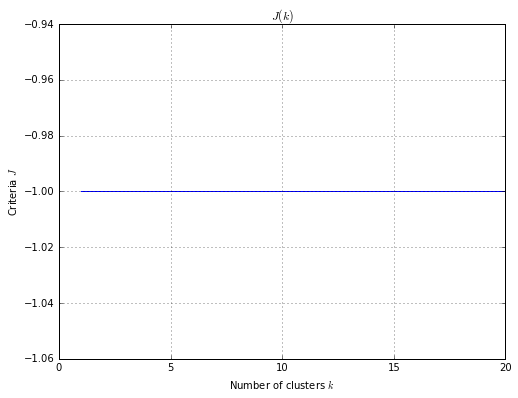

In [141]:
ks = range(1, 21)
criteria = np.zeros(len(ks))



for i, k in enumerate(ks):
    cls = Clustering()
    test_y = cls.fit_predict(test_x)
    criteria[i] = quality(test_x, test_y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

 Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [18]:
k = 5
cls = Clustering()
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11439
[t-SNE] Computed conditional probabilities for sample 2000 / 11439
[t-SNE] Computed conditional probabilities for sample 3000 / 11439
[t-SNE] Computed conditional probabilities for sample 4000 / 11439
[t-SNE] Computed conditional probabilities for sample 5000 / 11439
[t-SNE] Computed conditional probabilities for sample 6000 / 11439
[t-SNE] Computed conditional probabilities for sample 7000 / 11439
[t-SNE] Computed conditional probabilities for sample 8000 / 11439
[t-SNE] Computed conditional probabilities for sample 9000 / 11439
[t-SNE] Computed conditional probabilities for sample 10000 / 11439
[t-SNE] Computed conditional probabilities for sample 11000 / 11439
[t-SNE] Computed conditional probabilities for sample 11439 / 11439
[t-SNE] Mean sigma: 0.074560
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.427081
[t-SN

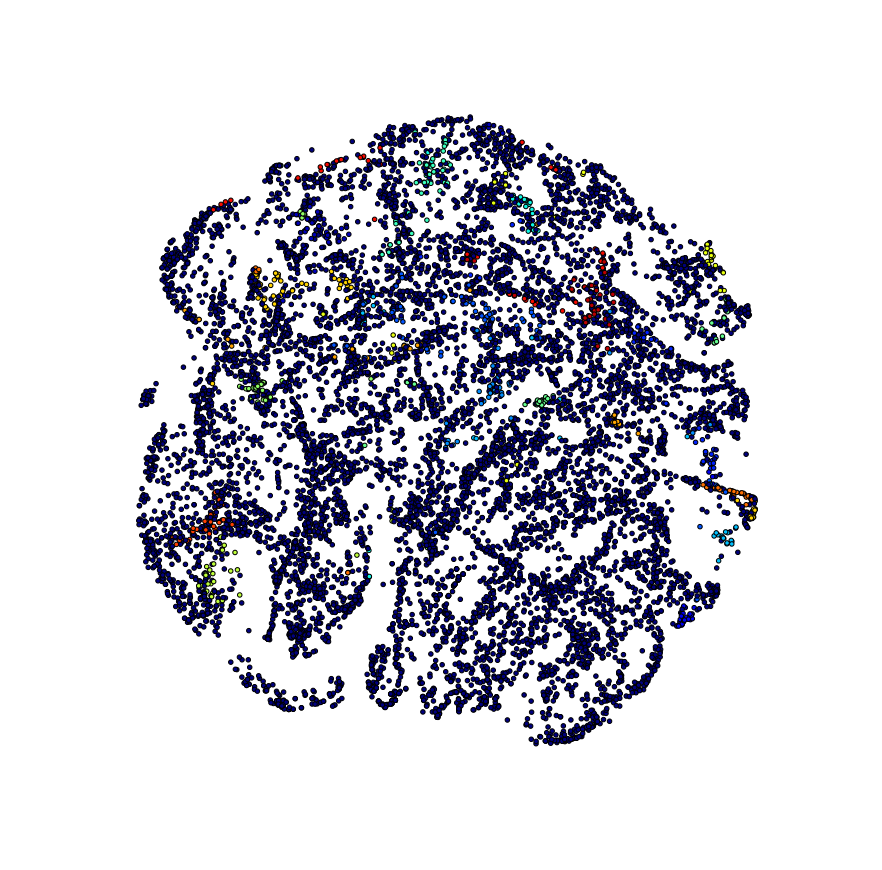

In [139]:
k = 19
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
#pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y1))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

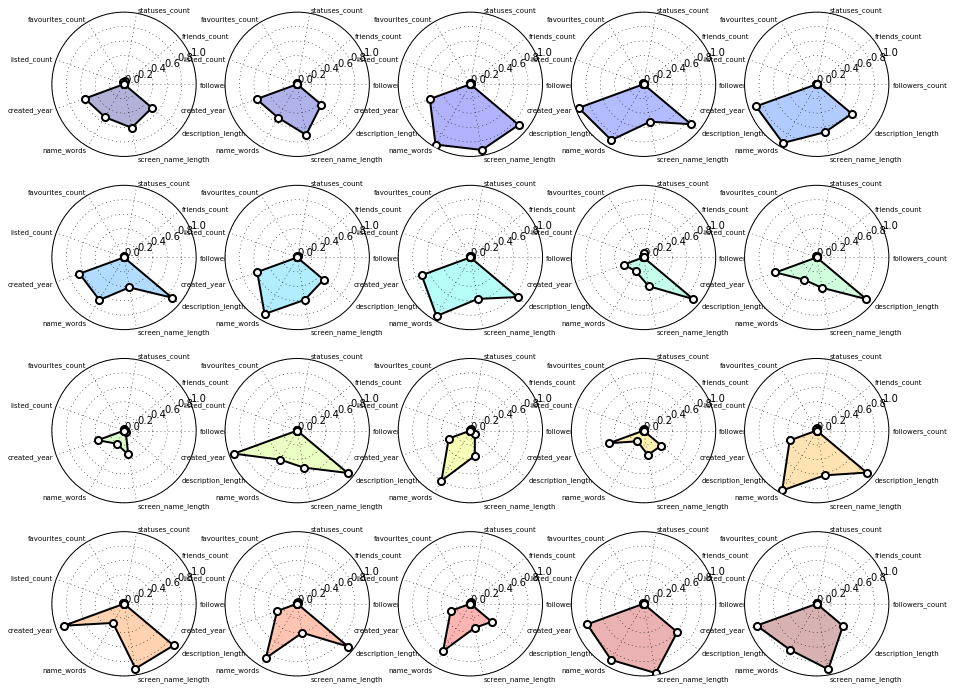

In [108]:
test_x_1 = x
test_y_1 = y1

def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(test_x_1, test_y_1) for test_x_1, test_y_1 in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(test_y_1)
for j, cluster in enumerate(clusters):    
    x_c = test_x_1[test_y_1 == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(5, 5, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.